# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

In [3]:
### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [4]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [5]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [6]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [7]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [8]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [9]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

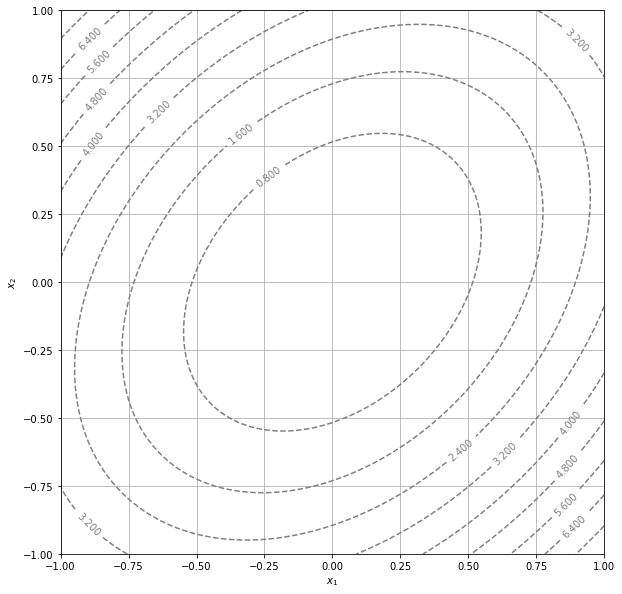

In [10]:
display_contour(f1,
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [11]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

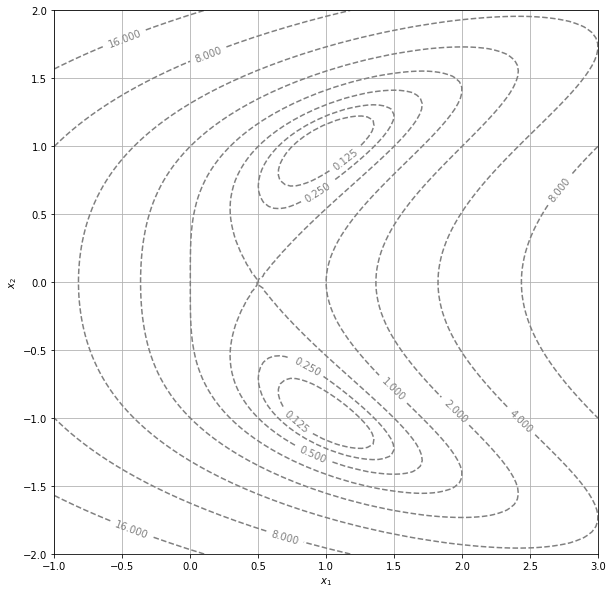

In [12]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [13]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

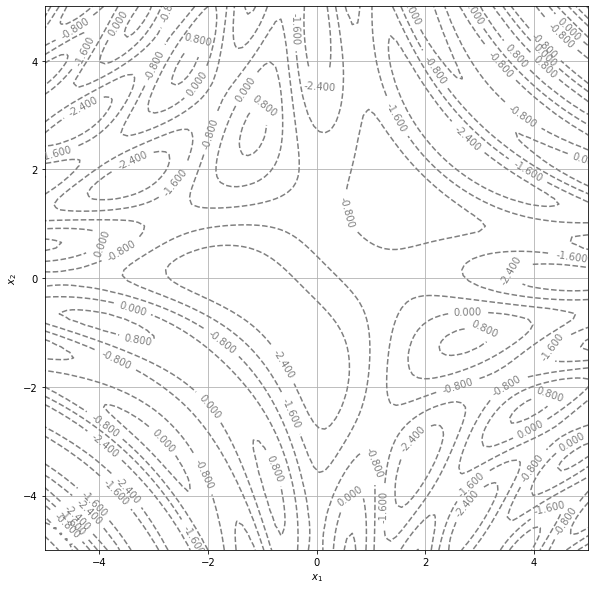

In [14]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

Comme {c} est fermé et que f est continue, on a donc : $ f^{-1}({{c}}) \  est \ fermé $
De plus, comme $f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$, 

il existe donc M $ \in \mathbb{R} , \ \forall (x_1,x_2) \in \mathbb {R}^2 \, \ f(x_1, x_2)>c $

D'où,   $ f^{-1}({{c}})$ est borné par M

Donc $ f^{-1}({{c}})$ est fermé et borné et inclue dans $ \mathbb{R}^2$ donc $ f^{-1}({{c}})$ est compact



Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

On a : pour $x_1,x_2 \in \mathbb{R}$ en posant $z_1 = (x_1,x_2), p(x_1, x_2) = det(z_1-x_0, \frac{\nabla f(x_0)}{\|\nabla f(x_0)\|} ) $

Ce qui correpond à l'aire orientée du parallèlogramme engendré par $z_1-x_0$ et $ \frac{\nabla f(x_0)}{\|\nabla f(x_0)\|}$

ce qui est aussi égale à $\| z_1-x_0 \| \sin(\theta) $ avec $\theta = ( z_1-x_0 ; \frac{\nabla f(x_0)}{\|\nabla f(x_0)\|} ) $ l'angle entre le vecteur déplacement et le gradient de f en $x_0$

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.



On pose: 
$
g : (x_1,x_2,t) \in \mathbb{R}^3 \mapsto \begin{pmatrix} f(x_1,x_2) - c \\ p(x_1,x_2) - t  \end{pmatrix}
$

g est continûment différentiable par composante (car f l'est et p aussi),

On souhaite ici appliquer le théorème des fonctions implicites: 
en posant x=$(x_1,x_2) \in \mathbb{R}^2$ , 
on a : 

$ \partial x g(x_{10},x_{20})(x_1,x_2) = \begin{pmatrix} \partial_1 f(x_0) & \partial_2 f(x_0) \\ \frac{\partial_1 
f(x_0)}{\|\nabla f(x_0)\|} &-\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} $ 

Or le déterminant de la matrice 2x2 ci-dessus vaut -$\|\nabla f(x_0)\| < 0 $ car on suppose que $\nabla f(x_0) \neq 0 $

Donc $ \partial x g(x_1,x_2,t) $ est inversible au voisinage de $x_0$ par continuité du déterminant et de l'application qui à $(x_1,x_2)$ associe la jacobienne de  $ g_1 : (x_1,x_2) \in \mathbb{R}^2 \mapsto \begin{pmatrix} f(x_1,x_2) - c \\ p(x_1,x_2) - t  \end{pmatrix} $

De plus, comme $g(x_{10},x_{20},0)=0$, d'après le théorème des fonctions implicites, il existe  un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ (ce qui donne un voisinage ouverte de {0}) tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.
 

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

On utilise la formule du cours qui donne directement $\gamma' (t)$ :

 $\forall t \in \left]-\varepsilon, \varepsilon \right[, \forall (x_1,x_2] \in \mathbb{R}^2 ,\gamma' (t) = - \partial _x g^{-1}(x_1,x_2,t).\partial _t g(x_1,x_2,t) $  (*)

 or $\partial _t g(x_1,x_2,t)= \begin{pmatrix} 0 \\ -1 \end{pmatrix} $

 et  $\partial _x g(x_{1},x_{2})=  \begin{pmatrix} \partial_1 f(x) & \partial_2 f(x) \\ \frac{\partial_2 
f(x_0)}{\|\nabla f(x_0)\|} &-\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} $

on évalue l'expression (*) en $x=x_0$

Avec la formule de l'inverse avec la transposée de la commatrice et la valeur du déterminant (bien différent de 0 en prenant $x$ = $x_0$ ) :

$ 
\partial _x g^{-1}(x_{10},x_{20})= \frac{-1}{\partial_1 f(x_0) \times \frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} + \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} \times \partial_2 f(x_0)} \begin{pmatrix} -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} & - \partial_2 f(x_0) \\ - \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & \partial_1 f(x_0) \end{pmatrix}  $

Donc $\gamma' (t) = \frac{-1}{\partial_1 f(x_0) \times \frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} + \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} \times \partial_2 f(x_0)} \begin{pmatrix} \partial_2 f(x_0) \\ -\partial_1 f(x_0) \end{pmatrix} $

$\gamma' (t)$ ne s'annule donc pas au voisinage de 0 ( comme $\nabla f(x_0) \neq 0 $ , on a : $(\partial_1 f(x_0),\partial_2 f(x_0)) \neq 0 $ )

On sait que $f \ o\  \gamma $ est constante égale à c , de plus, f et $\gamma$ sont continûment différentiable, donc en différentiant l'expression, on a :


$J_f(\gamma (t)) . \gamma ' (t) = 0 $

Comme $J_f(\gamma (t))$ = $\nabla f(\gamma(t))^{T}$

on a alors ,  $\nabla f(\gamma(t))$ est bien orthogonal à $\gamma ' (t)$ pour t au voisinage de 0 (d'après la formule du produit scalaire dans $\mathbb{R}^n$)


## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [15]:
N = 200
eps = 1*10**(-6)

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [16]:
def Newton(F, x0, y0, eps=eps, N=N):
    for i in range(N):
        X0=np.array([x0, y0])
        Q=np.linalg.inv(J(F)(x0,y0))
        X=X0-Q.dot(F(x0,y0))                   #d'après la formule f(x_n+1)= f(x_n) + J_f(x_0).(x_n+1 - x_n), avec f(x_n+1) = o (f(x_n))
        x,y = X[0],X[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:     
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

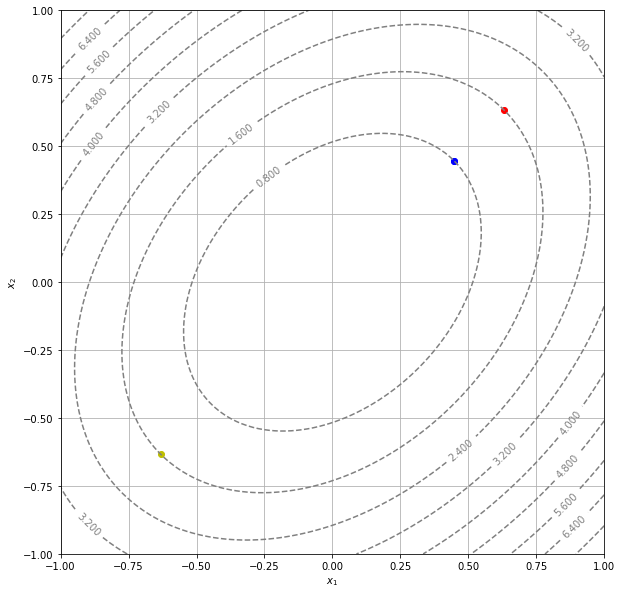

In [17]:
def f1s1(x1, x2):
    return np.array([3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 - 0.8 , x1-x2])

def f1s2(x1, x2):
    return np.array([3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 - 1.6 , x1-x2])


display_contour(f1,
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.scatter(Newton(f1s1,0.15,0.8,eps,N)[0],Newton(f1s1,0.15,0.8,eps,N)[1],color='b')  #test pour differentes conditions initiales et de ligne de niveau
plt.scatter(Newton(f1s1,0.15,0.15,eps,N)[0],Newton(f1s1,0.15,0.15,eps,N)[1],color='b')
plt.scatter(Newton(f1s2,0.70,0.7,eps,N)[0],Newton(f1s2,0.7,0.7,eps,N)[1],color='r')
plt.scatter(Newton(f1s2,-0.15,-0.15,eps,N)[0],Newton(f1s2,-0.15,-0.15,eps,N)[1],color='y')

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

![g%C3%A9n%C3%A9ration-points.png](attachment:g%C3%A9n%C3%A9ration-points.png)

In [18]:
def level_curve(f, x0, y0, delta=0.1, N=100, eps=eps):
    c=f(x0,y0)
    T=np.empty((2,N))
    for i in range(N):
        T[0, i] , T[1, i] = x0 , y0
        v=delta*grad(f)(x0,y0)/np.linalg.norm(grad(f)(x0,y0))
        def F(x1,y1):
             return np.array([(x1-x0)**2+(y1-y0)**2-delta**2 , f(x1,y1)-c])   #condition ligne de niveau et à distance delta du pt précédent
        R = np.array([[0,1],[-1,0]])                                          #matrice de rotation d'angle -pi/2 (pour se situer "à droite du gradient")
        z = np.array([x0,y0]) + np.dot(R, v)
        x0,y0 = Newton(F, z[0], z[1], eps, 100)   # 100 est une valeur arbitraire
    return T

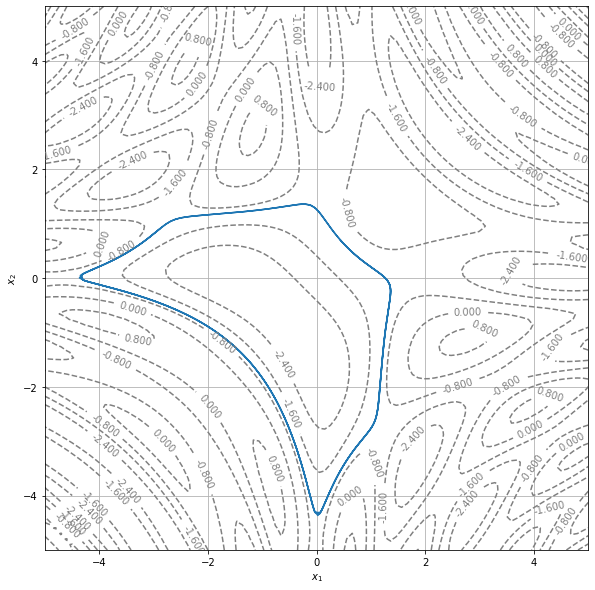

In [19]:
N=500
Z = level_curve(f3,0.44,.7,0.1,N,1*10**(-12))
X = Z[0]
Y = Z[1]
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
 
plt.plot(X, Y)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

In [20]:
delta=0.1
def intersection(segment1,segment2): #prend en arguments deux listes avec les coordonnées des points "engendrant" les deux segments ; renvoie True ssi les deux segments s'intersectent
    xA, yA = segment1[0][0], segment1[0][1]
    xB, yB = segment1[1][0], segment1[1][1]
    
    xC, yC = segment2[0][0], segment2[0][1]
    xD, yD = segment2[1][0], segment2[1][1]

    a1 = (yA - yB)/(xA - xB)
    b1 = (xA*yB - yA*xB)/(xA - xB) # y = a1*x +b1 est l'équation de la droite engendrée par le segment1

    a2 = (yC - yD)/(xC - xD)
    b2 = (xC*yD - yC*xD)/(xC - xD) 
    
    if a1!=a2:
        x0, y0 = (b2 - b1)/(a1 - a2), (a1*b2 - a2*b1)/(a1 - a2) # à partir des deux équations vérifiées par (x0, y0) le point d'intersection des droites (qui existe car les coefficients directeurs sont différents), on détermine x0 et y0
        if (xA-x0)**2 + (yA-y0)**2 <= delta**2 and (xB-x0)**2 + (yB-y0)**2 <= delta**2 and (xC -x0)**2 + (yC-y0)**2 <= delta**2 and (xD-x0)**2 + (yD-y0)**2 <= delta**2:
            return True
    return False

In [25]:
def level_curve2(f, x0, y0, delta=0.1, N=1000, eps=eps):
    c=f(x0,y0)
    def a_droite(x,y):
        r,t=grad(f)(x,y)[1],-grad(f)(x,y)[0]
        z=delta/((r*r+t*t)**0.5)*r
        e=delta/((r*r+t*t)**0.5)*t
        return (x+z),(y+e)
    L=[[x0,y0]]
    for i in range(0,4):
        p1=L[i][0]
        p2=L[i][1]
        def F(x1,y1):
            return np.array([(x1-p1)**2+(y1-p2)**2-delta**2 , f(x1,y1)-c])
        z,e= a_droite(p1,p2)
        x1,y1 = Newton(F, z, e, eps, 100)
        L.append([x1,y1])
    segment1 = [[x0, y0], [L[1][0], L[1][1]]]
    segment2 = [[L[2][0], L[2][1]], [L[3][0], L[3][1]]]
    i=3
    while not intersection(segment1, segment2) and i<N:
        p1=L[i][0]
        p2=L[i][1]
        def F(x1,y1):
            return np.array([(x1-p1)**2+(y1-p2)**2-delta**2 , f(x1,y1)-c])
        z,e = a_droite(p1,p2)
        x1,y1 = Newton(F, z, e, eps, 100)
        L.append([x1,y1])
        segment2 = [[L[i-1][0], L[i-1][1]], [L[i][0], L[i][1]]]
        i+=1
    print (i)

    return np.array(L).T
        

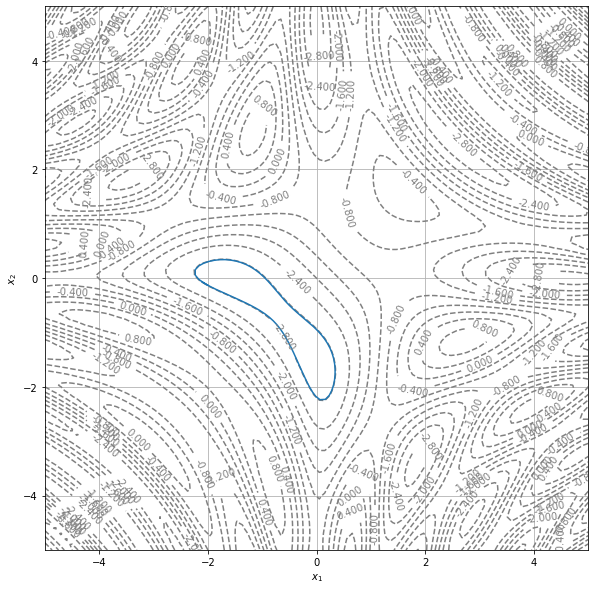

In [22]:
N=300
Z = level_curve2(f3,-2.,-0.13,0.1,N,10**(-12))
X = Z[0]
Y = Z[1]
display_contour(f3,
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.plot(X, Y)

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.


Supposons $\gamma$ qui vérifie les critères demandés : 

On a : $\gamma(0) = P_1$ donc $(a,d)=P_1$
$\gamma(1) = P_2$ donc $(a,d) + (b,e) + (c,f) = P_2 $

la condition sur les dérivées en 0 et 1 nous fournit $ \lambda,\  \mu \in \mathbb{R}^+$ tel que :

$\gamma'(0)= \lambda  u_1 \ et \  \gamma'(1) = \mu  u_2$

Donc : $(b,e)=\lambda  u_1 \  et \ (b,e) + 2(c,f) = \mu u_2 $

 par combinaison , $(c,f) = \frac {\mu u_2 - \lambda u_1 }{2} $


donc $(b,e)= \lambda u_1$  et on a alors par combinaison avec les équations précédentes : $ 2(a,b) + (b,e) + (b+2c,e+2f) = 2 P_2 $

d'où, $\mu u_2 + \lambda u_1= 2 \overrightarrow{P_1P_2}  $

donc nécessairement : 



-si $(u_1,u_2) $ est libre, alors  $\begin{pmatrix} \lambda \\ \mu \end{pmatrix}= 2 \begin {pmatrix} u_1 & u_2 \end{pmatrix} ^{-1} \overrightarrow{P_1P_2} $

-si $(u_1,u_2) $ est lié, et  $ \overrightarrow{P_1P_2}$ n'est pas colinéaire à $u_1$, il n'y a pas de solution possible.

si $u_1$ et $u_2$ sont positivement colinéaires et $ \overrightarrow{P_1P_2}$ est colinéaire à $u_1$, alors en prenant $\gamma$ le segment reliant $P_1$ et $P_2$ alors $\gamma$ convient 

si $u_1$ et $u_2$ ne sont pas positivement colinéaires et $ \overrightarrow{P_1P_2}$ est colinéaire à $u_1$ ou $u_2$, alors il n'y a pas de solution $\gamma$ qui convient.

Donc dans tous les cas, si $(u_1,u_2) $ est lié, alors on prend le segment reliant $P_1$ et $P_2$.



Réciproquement, si $(u_1,u_2) $ est libre, et  $\begin{pmatrix} \lambda \\ \mu \end{pmatrix}= 2 \begin {pmatrix} u_1 & u_2 \end{pmatrix} ^{-1} \overrightarrow{P_1P_2} \in \ \mathbb{R}^+ $, alors on trouve a,b,c,d,e,f avec les formules au-dessus.




 


#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [23]:
def gamma(t, P1, P2, u1, u2):
    if np.linalg.det([u1, u2]) == 0 or np.dot(np.linalg.inv(np.array([u1, u2])), P2-P1)[0] < 0 or np.dot(np.linalg.inv(np.array([u1, u2])), P2-P1)[1] < 0:
        return np.array([P1[0]+(P2[0]-P1[0])*t,P1[1]+(P2[1]-P1[1])*t])
    else:
        a, d = P1[0], P1[1]
        Lambda, mu = 2*np.dot(np.linalg.inv(np.array([u1, u2]).T), P2-P1)[0], 2*np.dot(np.linalg.inv(np.array([u1, u2]).T), P2-P1)[1]
        b, e = Lambda*u1[0], Lambda*u1[1]
        c, f = (mu*u2[0] - Lambda*u1[0])/2, (mu*u2[1] - Lambda*u1[1])/2
        x = a + b*t + c*t**2
        y = d + e*t + f*t**2
        return np.array([x, y])

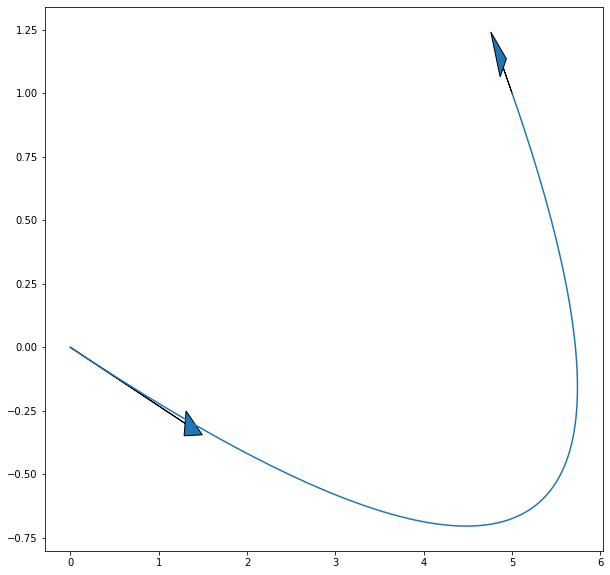

In [24]:
P1=np.array([0, 0])
P2=np.array([5, 1])
u1=np.array([13, -3])
u2=np.array([-1, 1])
t=np.linspace(0,1,100)

gamma(1,P1,P2,u1,u2)
g=gamma(t, P1, P2, u1, u2)
plt.arrow(P1[0],P1[1],u1[0]/10,u1[1]/10,head_width=0.1, head_length=0.2,ec='black')
plt.arrow(P2[0],P2[1],u2[0]/10,u2[1]/10,head_width=0.1, head_length=0.2,ec='black')
plt.plot(g[0], g[1])

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.